In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle as pk
import random
import sys
from sklearn.model_selection import train_test_split
from random import shuffle
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

### The Vanilla Autoencoder Model

In [2]:
# Define the autoencoder
class Encoder(nn.Module):
    def __init__(self, n_input, n_bn, dp_rate, leaky_r):
        super().__init__()
        self.encoder_l1 = nn.Linear(in_features = n_input, out_features = 256)
        self.encoder_l2 = nn.Linear(in_features = 256, out_features = 128)
        self.encoder_l3 = nn.Linear(in_features = 128, out_features = 64)
        self.encoder_l4 = nn.Linear(in_features = 64, out_features = 32)
        self.encoder_l5 = nn.Linear(in_features = 32, out_features = n_bn)
        
        self.dropout = nn.Dropout(p = dp_rate)
        self.activation = nn.LeakyReLU(negative_slope=leaky_r, inplace=True)
    
    def forward(self, x):
        x = self.activation(self.dropout(self.encoder_l1(x)))
        x = self.activation(self.dropout(self.encoder_l2(x)))
        x = self.activation(self.dropout(self.encoder_l3(x)))
        x = self.activation(self.dropout(self.encoder_l4(x)))
        x = self.activation(self.encoder_l5(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, n_input, n_bn, dp_rate, leaky_r):
        super().__init__()
        self.decoder_l1 = nn.Linear(in_features = n_bn, out_features = 32)
        self.decoder_l2 = nn.Linear(in_features = 32, out_features = 64)
        self.decoder_l3 = nn.Linear(in_features = 64, out_features = 128)
        self.decoder_l4 = nn.Linear(in_features = 128, out_features = 256)
        self.decoder_l5 = nn.Linear(in_features = 256, out_features = n_input)
        
        self.dropout = nn.Dropout(p = dp_rate)
        self.activation = nn.LeakyReLU(negative_slope=leaky_r, inplace=True)
    
    def forward(self, x):
        x = self.activation(self.dropout(self.decoder_l1(x)))
        x = self.activation(self.dropout(self.decoder_l2(x)))
        x = self.activation(self.dropout(self.decoder_l3(x)))
        x = self.activation(self.dropout(self.decoder_l4(x)))
        x = self.activation(self.decoder_l5(x))
        return x
    
class AutoEncoder(nn.Module):
    def __init__(self, n_input, n_bn, dp_rate, leaky_r):
        super().__init__()
        self.encoder = Encoder(n_input, n_bn, dp_rate, leaky_r)
        self.decoder = Decoder(n_input, n_bn, dp_rate, leaky_r)
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [13]:
# Define hyperparameters
n_input = 279
n_bn = 16
dp_rate = 0.2
leaky_r = 0.01
l_r = 0.0002
wd_r = 0.00000
batch_size = 500
num_epoch = 3
threshold = 0.03

In [14]:
model = AutoEncoder(n_input, n_bn, dp_rate, leaky_r)
criterion = nn.BCEWithLogitsLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=l_r, weight_decay=wd_r)
model.parameters

<bound method Module.parameters of AutoEncoder(
  (encoder): Encoder(
    (encoder_l1): Linear(in_features=279, out_features=256, bias=True)
    (encoder_l2): Linear(in_features=256, out_features=128, bias=True)
    (encoder_l3): Linear(in_features=128, out_features=64, bias=True)
    (encoder_l4): Linear(in_features=64, out_features=32, bias=True)
    (encoder_l5): Linear(in_features=32, out_features=16, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (activation): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (decoder): Decoder(
    (decoder_l1): Linear(in_features=16, out_features=32, bias=True)
    (decoder_l2): Linear(in_features=32, out_features=64, bias=True)
    (decoder_l3): Linear(in_features=64, out_features=128, bias=True)
    (decoder_l4): Linear(in_features=128, out_features=256, bias=True)
    (decoder_l5): Linear(in_features=256, out_features=279, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (activation): LeakyReLU(negative_slope=0.01, in

### Data Preprocessing

In [5]:
normalized_data = pd.read_feather('./Processed_New_Data.ftr')[:2500000]

In [6]:
normalized_data

,FUND_TYPE_0,FUND_TYPE_1,FUND_TYPE_2,FUND_TYPE_3,FUND_TYPE_4,FUND_TYPE_5,FUND_TYPE_6,FUND_TYPE_7,FUND_TYPE_8,FUND_TYPE_9,...,TRAN_CODE_188,COST,AMOUNT,INTEREST_VALUE,QUANTITY,TRANSACTIONCANCELLED,Trade_Month,Trade_Day,trade_year,trade_dayofyear
0,1,0,0,0,0,0,0,0,0,0,...,0,-0.29,0.00,-0.35,-0.0259,1,2.0,1.0,0.0,90.0
1,1,0,0,0,0,0,0,0,0,0,...,0,-9.93,0.00,0.00,0.0000,0,2.0,1.0,0.0,90.0
2,1,0,0,0,0,0,0,0,0,0,...,0,-43.29,0.00,0.00,0.0000,0,2.0,1.0,0.0,90.0
3,1,0,0,0,0,0,0,0,0,0,...,0,-1.21,0.00,0.00,0.0000,0,2.0,1.0,0.0,90.0
4,1,0,0,0,0,0,0,0,0,0,...,0,-27.33,0.00,0.00,0.0000,0,2.0,1.0,0.0,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499995,1,0,0,0,0,0,0,0,0,0,...,0,12.27,0.00,12.27,1.1797,0,7.0,0.0,0.0,243.0
2499996,1,0,0,0,0,0,0,0,0,0,...,0,0.00,-96.39,0.00,0.0000,0,7.0,0.0,0.0,243.0
2499997,1,0,0,0,0,0,0,0,0,0,...,0,-39.15,0.00,0.00,0.0000,0,7.0,0.0,0.0,243.0
2499998,1,0,0,0,0,0,0,0,0,0,...,0,-0.40,0.00,0.00,0.0000,0,7.0,0.0,0.0,243.0


In [7]:
# normalized_data = pd.read_feather('./Processed_New_Data.ftr')[:2500000]
# normalized_data = pd.read_feather('./normalized_one_hot_encoded_data_Charlie.ftr')
# normalized_data = pd.read_feather('./one_hot_encoded_data_Merge_Data.ftr')[:2500000]
normalized_data.drop(["trade_year","trade_dayofyear"],axis=1, inplace=True)
normalized_data["AMOUNT"] = normalized_data["AMOUNT"]!= 0
normalized_data["INTEREST_VALUE"] = normalized_data["INTEREST_VALUE"] != 0
normalized_data["COST"] = normalized_data["COST"]!= 0
normalized_data["QUANTITY"] = normalized_data["QUANTITY"]!= 0
normalized_data = normalized_data.assign(Trade_Month_1=normalized_data["Trade_Month"]==1)
normalized_data = normalized_data.assign(Trade_Month_2=normalized_data["Trade_Month"]==2)
normalized_data = normalized_data.assign(Trade_Month_3=normalized_data["Trade_Month"]==3)
normalized_data = normalized_data.assign(Trade_Month_4=normalized_data["Trade_Month"]==4)
normalized_data = normalized_data.assign(Trade_Month_5=normalized_data["Trade_Month"]==5)
normalized_data = normalized_data.assign(Trade_Month_6=normalized_data["Trade_Month"]==6)
normalized_data = normalized_data.assign(Trade_Month_7=normalized_data["Trade_Month"]==7)
normalized_data = normalized_data.assign(Trade_Month_8=normalized_data["Trade_Month"]==8)
normalized_data = normalized_data.assign(Trade_Month_9=normalized_data["Trade_Month"]==9)
normalized_data = normalized_data.assign(Trade_Month_10=normalized_data["Trade_Month"]==10)
normalized_data = normalized_data.assign(Trade_Month_11=normalized_data["Trade_Month"]==11)
normalized_data = normalized_data.assign(Trade_Month_12=normalized_data["Trade_Month"]==12)
normalized_data = normalized_data.assign(Trade_Day_1=normalized_data["Trade_Day"]==1)
normalized_data = normalized_data.assign(Trade_Day_2=normalized_data["Trade_Day"]==2)
normalized_data = normalized_data.assign(Trade_Day_3=normalized_data["Trade_Day"]==3)
normalized_data = normalized_data.assign(Trade_Day_4=normalized_data["Trade_Day"]==4)
normalized_data = normalized_data.assign(Trade_Day_5=normalized_data["Trade_Day"]==5)
normalized_data = normalized_data.assign(Trade_Day_6=normalized_data["Trade_Day"]==6)
normalized_data = normalized_data.assign(Trade_Day_7=normalized_data["Trade_Day"]==7)
normalized_data = normalized_data.assign(Trade_Day_8=normalized_data["Trade_Day"]==8)
normalized_data = normalized_data.assign(Trade_Day_9=normalized_data["Trade_Day"]==9)
normalized_data = normalized_data.assign(Trade_Day_10=normalized_data["Trade_Day"]==10)
normalized_data = normalized_data.assign(Trade_Day_11=normalized_data["Trade_Day"]==11)
normalized_data = normalized_data.assign(Trade_Day_12=normalized_data["Trade_Day"]==12)
normalized_data = normalized_data.assign(Trade_Day_13=normalized_data["Trade_Day"]==13)
normalized_data = normalized_data.assign(Trade_Day_14=normalized_data["Trade_Day"]==14)
normalized_data = normalized_data.assign(Trade_Day_15=normalized_data["Trade_Day"]==15)
normalized_data = normalized_data.assign(Trade_Day_16=normalized_data["Trade_Day"]==16)
normalized_data = normalized_data.assign(Trade_Day_17=normalized_data["Trade_Day"]==17)
normalized_data = normalized_data.assign(Trade_Day_18=normalized_data["Trade_Day"]==18)
normalized_data = normalized_data.assign(Trade_Day_19=normalized_data["Trade_Day"]==19)
normalized_data = normalized_data.assign(Trade_Day_20=normalized_data["Trade_Day"]==20)
normalized_data = normalized_data.assign(Trade_Day_21=normalized_data["Trade_Day"]==21)
normalized_data = normalized_data.assign(Trade_Day_22=normalized_data["Trade_Day"]==22)
normalized_data = normalized_data.assign(Trade_Day_23=normalized_data["Trade_Day"]==23)
normalized_data = normalized_data.assign(Trade_Day_24=normalized_data["Trade_Day"]==24)
normalized_data = normalized_data.assign(Trade_Day_25=normalized_data["Trade_Day"]==25)
normalized_data = normalized_data.assign(Trade_Day_26=normalized_data["Trade_Day"]==26)
normalized_data = normalized_data.assign(Trade_Day_27=normalized_data["Trade_Day"]==27)
normalized_data = normalized_data.assign(Trade_Day_28=normalized_data["Trade_Day"]==28)
normalized_data = normalized_data.assign(Trade_Day_29=normalized_data["Trade_Day"]==29)
normalized_data = normalized_data.assign(Trade_Day_30=normalized_data["Trade_Day"]==30)
normalized_data = normalized_data.assign(Trade_Day_31=normalized_data["Trade_Day"]==31)
normalized_data.drop(["Trade_Day","Trade_Month"],axis=1, inplace=True)
normalized_data = normalized_data.astype(float)
# Data preparing
false_index = normalized_data['TRANSACTIONCANCELLED'] == 1
false_data = normalized_data[false_index]
true_index = normalized_data['TRANSACTIONCANCELLED'] == 0
true_data = normalized_data[true_index]

X_true = true_data.drop('TRANSACTIONCANCELLED', axis=1).values
y_true = true_data['TRANSACTIONCANCELLED'].values
X_false = false_data.drop('TRANSACTIONCANCELLED', axis=1).values
y_false = false_data['TRANSACTIONCANCELLED'].values

print(X_true.shape, y_true.shape, X_false.shape, y_false.shape)
X_true_train, X_true_val, y_true_train, y_true_val = train_test_split(X_true, y_true, test_size=0.01, random_state=42)
X_true_val, X_true_test, y_true_val, y_true_test = train_test_split(X_true_val, y_true_val, test_size=0.4, random_state=42)
X_false_train, X_false_val, y_false_train, y_false_val = train_test_split(X_false, y_false, test_size=0.4, random_state=42)
X_false_val, X_false_test, y_false_val, y_false_test = train_test_split(X_false_val, y_false_val, test_size=0.5, random_state=42)

print(y_true_val.shape, y_false_val.shape)
print(X_true_test.shape, y_true_test.shape, X_false_test.shape, y_false_test.shape)
X_true_train = torch.FloatTensor(X_true_train)
X_false_train = torch.FloatTensor(X_false_train)
y_true_train = torch.FloatTensor(y_true_train)
y_false_train = torch.FloatTensor(y_false_train)
X_true_val = torch.FloatTensor(X_true_val)
y_true_val = torch.FloatTensor(y_true_val)
X_false_val = torch.FloatTensor(X_false_val)
y_false_val = torch.FloatTensor(y_false_val)
X_true_test = torch.FloatTensor(X_true_test)
y_true_test = torch.FloatTensor(y_true_test)
X_false_test = torch.FloatTensor(X_false_test)
y_false_test = torch.FloatTensor(y_false_test)
y_true_val.numpy()[10000]

(2443333, 279) (2443333,) (56667, 279) (56667,)
(14660,) (11333,)
(9774, 279) (9774,) (11334, 279) (11334,)


0.0

In [8]:
normalized_data

,FUND_TYPE_0,FUND_TYPE_1,FUND_TYPE_2,FUND_TYPE_3,FUND_TYPE_4,FUND_TYPE_5,FUND_TYPE_6,FUND_TYPE_7,FUND_TYPE_8,FUND_TYPE_9,...,Trade_Day_22,Trade_Day_23,Trade_Day_24,Trade_Day_25,Trade_Day_26,Trade_Day_27,Trade_Day_28,Trade_Day_29,Trade_Day_30,Trade_Day_31
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499995,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2499996,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2499997,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2499998,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
def random_a_batch(x, y, batch_size):
    length = x.shape[0]
    start = random.randint(0, (length - batch_size))
    return x[start : start + batch_size], y[start : start + batch_size]

def get_a_batch(x, y, start, batch_size):
    length = x.shape[0]
    if (start + batch_size) <= length:
        return x[start : start + batch_size], y[start : start + batch_size]
    else:
        return x[start : ], y[start : ]

def binary_acc(y_hat, y, threshold):
    t = nn.Threshold(threshold, 0)
    y_pred = t(y_hat)
    y_pred = torch.ceil(y_pred)
    correct_results_sum = (y_pred == y).sum().float()
    acc = correct_results_sum/y.shape[0] 
    return acc

def get_precision_and_recall(y_hat, y, threshold):
    t = nn.Threshold(threshold, 0)
    y_pred = t(y_hat)
    y_pred = torch.ceil(y_pred)
    y_pred = torch.squeeze(y_pred)
    
    num_tp = (y_pred + y == 2).sum().float()
    num_fp = (y_pred - y == 1).sum().float()
    num_tn = (y_pred + y == 0).sum().float()
    num_fn = (y_pred - y == -1).sum().float()
    
    precision = num_tp / (num_tp + num_fp)
    recall = num_tp / (num_tp + num_fn)
    
    return precision, recall

### Training

In [15]:
# actual training, First 3 epochs

# tracing the loss along the way
meta_info = {}
meta_info['trn_loss'] = []
meta_info['trn_acc'] = []
meta_info['val_loss'] = []
meta_info['val_acc'] = []
iteration = 0

num_trn = X_true_train.shape[0]

model = AutoEncoder(n_input, n_bn, dp_rate, leaky_r)
optimizer = torch.optim.Adam(model.parameters(), lr=l_r, weight_decay=wd_r)
for ep in range(num_epoch):

    trn_batch_start = 0
    val_batch_start = 0

    avg_trn_loss = 0
    avg_trn_acc = 0

    print('TRN:', flush=True)
    i = 0
    while (trn_batch_start <= num_trn - 1): 
        i += 1
        # loop to iterate over training set
        X_trn_batch, y_trn_batch = get_a_batch(X_true_train, y_true_train, trn_batch_start, batch_size)

        iteration += 1
        trn_batch_start += batch_size

        # forward and backward propagation
        y_hat = model.forward(X_trn_batch)
        loss = criterion(y_hat, X_trn_batch)

        loss = torch.mean(loss)

        if i % 1000 == 0:
            print(' + ', loss, end='', flush=True)

        '''if i % 10 == 0:
            print(f'Loop: {i} Loss: {loss}')'''

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_trn_loss = avg_trn_loss + loss

    avg_trn_loss = avg_trn_loss*batch_size/num_trn

    #Validation
    print('VAL:', flush=True)

    y_val_hat = model.forward(X_true_val)
    val_loss = criterion(y_val_hat, X_true_val)
    avg_val_loss = torch.mean(val_loss)

    print('', flush=True)
    print('\nEp.%05d - TRN: loss %.3f VAL: loss %.3f' % (ep, avg_trn_loss, avg_val_loss), flush=True)

    # save learning meta information
    meta_info['trn_loss'].append(avg_trn_loss)
    meta_info['val_loss'].append(avg_val_loss)
torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
        }, "autoencoder_model.pt")

TRN:
 +  tensor(0.0618, grad_fn=<MeanBackward0>) +  tensor(0.0603, grad_fn=<MeanBackward0>) +  tensor(0.0594, grad_fn=<MeanBackward0>) +  tensor(0.0587, grad_fn=<MeanBackward0>)VAL:


Ep.00000 - TRN: loss 0.080 VAL: loss 0.059
TRN:
 +  tensor(0.0576, grad_fn=<MeanBackward0>) +  tensor(0.0581, grad_fn=<MeanBackward0>) +  tensor(0.0501, grad_fn=<MeanBackward0>) +  tensor(0.0442, grad_fn=<MeanBackward0>)VAL:


Ep.00001 - TRN: loss 0.052 VAL: loss 0.043
TRN:
 +  tensor(0.0414, grad_fn=<MeanBackward0>) +  tensor(0.0411, grad_fn=<MeanBackward0>) +  tensor(0.0395, grad_fn=<MeanBackward0>) +  tensor(0.0384, grad_fn=<MeanBackward0>)VAL:


Ep.00002 - TRN: loss 0.040 VAL: loss 0.038


In [16]:
# actual training, later epochs
# tracing the loss along the way
meta_info = {}
meta_info['trn_loss'] = []
meta_info['trn_acc'] = []
meta_info['val_loss'] = []
meta_info['val_acc'] = []
iteration = 0

num_trn = X_true_train.shape[0]

model = AutoEncoder(n_input, n_bn, dp_rate, leaky_r)
optimizer = torch.optim.Adam(model.parameters(), lr=l_r, weight_decay=wd_r)
checkpoint = torch.load("autoencoder_model.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for ep in range(num_epoch):

    trn_batch_start = 0
    val_batch_start = 0

    avg_trn_loss = 0
    avg_trn_acc = 0

    print('TRN:', flush=True)
    i = 0
    while (trn_batch_start <= num_trn - 1): 
        i += 1
        # loop to iterate over training set
        X_trn_batch, y_trn_batch = get_a_batch(X_true_train, y_true_train, trn_batch_start, batch_size)

        iteration += 1
        trn_batch_start += batch_size

        # forward and backward propagation
        y_hat = model.forward(X_trn_batch)
        loss = criterion(y_hat, X_trn_batch)
        loss = torch.mean(loss)

        if i % 1000 == 0:
            print(' + ', loss, end='', flush=True)

        '''if i % 10 == 0:
            print(f'Loop: {i} Loss: {loss}')'''

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_trn_loss = avg_trn_loss + loss


    avg_trn_loss = avg_trn_loss*batch_size/num_trn

    #Validation
    print('VAL:', flush=True)

    y_val_hat = model.forward(X_true_val)
    val_loss = criterion(y_val_hat, X_true_val)
    avg_val_loss = torch.mean(val_loss)

    print('', flush=True)

    print('\nEp.%05d - TRN: loss %.3f VAL: loss %.3f' % (ep, avg_trn_loss, avg_val_loss), flush=True)


    # save learning meta information
    meta_info['trn_loss'].append(avg_trn_loss)
    meta_info['val_loss'].append(avg_val_loss)
torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
        }, "autoencoder_model.pt")

TRN:
 +  tensor(0.0375, grad_fn=<MeanBackward0>) +  tensor(0.0364, grad_fn=<MeanBackward0>) +  tensor(0.0364, grad_fn=<MeanBackward0>) +  tensor(0.0355, grad_fn=<MeanBackward0>)VAL:


Ep.00000 - TRN: loss 0.036 VAL: loss 0.035
TRN:
 +  tensor(0.0346, grad_fn=<MeanBackward0>) +  tensor(0.0338, grad_fn=<MeanBackward0>) +  tensor(0.0342, grad_fn=<MeanBackward0>) +  tensor(0.0330, grad_fn=<MeanBackward0>)VAL:


Ep.00001 - TRN: loss 0.034 VAL: loss 0.033
TRN:
 +  tensor(0.0328, grad_fn=<MeanBackward0>) +  tensor(0.0330, grad_fn=<MeanBackward0>) +  tensor(0.0329, grad_fn=<MeanBackward0>) +  tensor(0.0314, grad_fn=<MeanBackward0>)VAL:


Ep.00002 - TRN: loss 0.032 VAL: loss 0.032


In [17]:
# actual training, later epochs
# tracing the loss along the way
meta_info = {}
meta_info['trn_loss'] = []
meta_info['trn_acc'] = []
meta_info['val_loss'] = []
meta_info['val_acc'] = []
iteration = 0

num_trn = X_true_train.shape[0]


model = AutoEncoder(n_input, n_bn, dp_rate, leaky_r)
optimizer = torch.optim.Adam(model.parameters(), lr=l_r, weight_decay=wd_r)
checkpoint = torch.load("autoencoder_model.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for ep in range(num_epoch):

    trn_batch_start = 0
    val_batch_start = 0

    avg_trn_loss = 0
    avg_trn_acc = 0

    print('TRN:', flush=True)
    i = 0
    while (trn_batch_start <= num_trn - 1): 
        i += 1
        # loop to iterate over training set
        X_trn_batch, y_trn_batch = get_a_batch(X_true_train, y_true_train, trn_batch_start, batch_size)

        iteration += 1
        trn_batch_start += batch_size

        # forward and backward propagation
        y_hat = model.forward(X_trn_batch)
        loss = criterion(y_hat, X_trn_batch)
        loss = torch.mean(loss)

        if i % 1000 == 0:
            print(' + ', loss, end='', flush=True)

        '''if i % 10 == 0:
            print(f'Loop: {i} Loss: {loss}')'''

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_trn_loss = avg_trn_loss + loss


    avg_trn_loss = avg_trn_loss*batch_size/num_trn

    #Validation
    print('VAL:', flush=True)

    y_val_hat = model.forward(X_true_val)
    val_loss = criterion(y_val_hat, X_true_val)
    avg_val_loss = torch.mean(val_loss)

    print('', flush=True)

    print('\nEp.%05d - TRN: loss %.3f VAL: loss %.3f' % (ep, avg_trn_loss, avg_val_loss), flush=True)


    # save learning meta information
    meta_info['trn_loss'].append(avg_trn_loss)
    meta_info['val_loss'].append(avg_val_loss)
torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
        }, "autoencoder_model.pt")

TRN:
 +  tensor(0.0310, grad_fn=<MeanBackward0>) +  tensor(0.0313, grad_fn=<MeanBackward0>) +  tensor(0.0315, grad_fn=<MeanBackward0>) +  tensor(0.0302, grad_fn=<MeanBackward0>)VAL:


Ep.00000 - TRN: loss 0.031 VAL: loss 0.030
TRN:
 +  tensor(0.0294, grad_fn=<MeanBackward0>) +  tensor(0.0310, grad_fn=<MeanBackward0>) +  tensor(0.0302, grad_fn=<MeanBackward0>) +  tensor(0.0293, grad_fn=<MeanBackward0>)VAL:


Ep.00001 - TRN: loss 0.030 VAL: loss 0.029
TRN:
 +  tensor(0.0289, grad_fn=<MeanBackward0>) +  tensor(0.0293, grad_fn=<MeanBackward0>) +  tensor(0.0299, grad_fn=<MeanBackward0>) +  tensor(0.0283, grad_fn=<MeanBackward0>)VAL:


Ep.00002 - TRN: loss 0.029 VAL: loss 0.028


In [18]:
# actual training, later epochs
# tracing the loss along the way
meta_info = {}
meta_info['trn_loss'] = []
meta_info['trn_acc'] = []
meta_info['val_loss'] = []
meta_info['val_acc'] = []
iteration = 0

num_trn = X_true_train.shape[0]


model = AutoEncoder(n_input, n_bn, dp_rate, leaky_r)
optimizer = torch.optim.Adam(model.parameters(), lr=l_r, weight_decay=wd_r)
checkpoint = torch.load("autoencoder_model.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for ep in range(num_epoch):

    trn_batch_start = 0
    val_batch_start = 0

    avg_trn_loss = 0
    avg_trn_acc = 0

    print('TRN:', flush=True)
    i = 0
    while (trn_batch_start <= num_trn - 1): 
        i += 1
        # loop to iterate over training set
        X_trn_batch, y_trn_batch = get_a_batch(X_true_train, y_true_train, trn_batch_start, batch_size)

        iteration += 1
        trn_batch_start += batch_size

        # forward and backward propagation
        y_hat = model.forward(X_trn_batch)
        loss = criterion(y_hat, X_trn_batch)
        loss = torch.mean(loss)

        if i % 1000 == 0:
            print(' + ', loss, end='', flush=True)

        '''if i % 10 == 0:
            print(f'Loop: {i} Loss: {loss}')'''

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_trn_loss = avg_trn_loss + loss


    avg_trn_loss = avg_trn_loss*batch_size/num_trn

    #Validation
    print('VAL:', flush=True)

    y_val_hat = model.forward(X_true_val)
    val_loss = criterion(y_val_hat, X_true_val)
    avg_val_loss = torch.mean(val_loss)

    print('', flush=True)

    print('\nEp.%05d - TRN: loss %.3f VAL: loss %.3f' % (ep, avg_trn_loss, avg_val_loss), flush=True)


    # save learning meta information
    meta_info['trn_loss'].append(avg_trn_loss)
    meta_info['val_loss'].append(avg_val_loss)
torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
        }, "autoencoder_model.pt")

TRN:
 +  tensor(0.0274, grad_fn=<MeanBackward0>) +  tensor(0.0294, grad_fn=<MeanBackward0>) +  tensor(0.0286, grad_fn=<MeanBackward0>) +  tensor(0.0276, grad_fn=<MeanBackward0>)VAL:


Ep.00000 - TRN: loss 0.028 VAL: loss 0.028
TRN:
 +  tensor(0.0270, grad_fn=<MeanBackward0>) +  tensor(0.0283, grad_fn=<MeanBackward0>) +  tensor(0.0280, grad_fn=<MeanBackward0>) +  tensor(0.0271, grad_fn=<MeanBackward0>)VAL:


Ep.00001 - TRN: loss 0.027 VAL: loss 0.027
TRN:
 +  tensor(0.0268, grad_fn=<MeanBackward0>) +  tensor(0.0275, grad_fn=<MeanBackward0>) +  tensor(0.0275, grad_fn=<MeanBackward0>) +  tensor(0.0270, grad_fn=<MeanBackward0>)VAL:


Ep.00002 - TRN: loss 0.027 VAL: loss 0.027


In [19]:
# actual training, later epochs
# tracing the loss along the way
meta_info = {}
meta_info['trn_loss'] = []
meta_info['trn_acc'] = []
meta_info['val_loss'] = []
meta_info['val_acc'] = []
iteration = 0

num_trn = X_true_train.shape[0]


model = AutoEncoder(n_input, n_bn, dp_rate, leaky_r)
optimizer = torch.optim.Adam(model.parameters(), lr=l_r, weight_decay=wd_r)
checkpoint = torch.load("autoencoder_model.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for ep in range(num_epoch):

    trn_batch_start = 0
    val_batch_start = 0

    avg_trn_loss = 0
    avg_trn_acc = 0

    print('TRN:', flush=True)
    i = 0
    while (trn_batch_start <= num_trn - 1): 
        i += 1
        # loop to iterate over training set
        X_trn_batch, y_trn_batch = get_a_batch(X_true_train, y_true_train, trn_batch_start, batch_size)

        iteration += 1
        trn_batch_start += batch_size

        # forward and backward propagation
        y_hat = model.forward(X_trn_batch)
        loss = criterion(y_hat, X_trn_batch)
        loss = torch.mean(loss)

        if i % 1000 == 0:
            print(' + ', loss, end='', flush=True)

        '''if i % 10 == 0:
            print(f'Loop: {i} Loss: {loss}')'''

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_trn_loss = avg_trn_loss + loss


    avg_trn_loss = avg_trn_loss*batch_size/num_trn

    #Validation
    print('VAL:', flush=True)

    y_val_hat = model.forward(X_true_val)
    val_loss = criterion(y_val_hat, X_true_val)
    avg_val_loss = torch.mean(val_loss)

    print('', flush=True)

    print('\nEp.%05d - TRN: loss %.3f VAL: loss %.3f' % (ep, avg_trn_loss, avg_val_loss), flush=True)


    # save learning meta information
    meta_info['trn_loss'].append(avg_trn_loss)
    meta_info['val_loss'].append(avg_val_loss)
torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
        }, "autoencoder_model.pt")

TRN:
 +  tensor(0.0264, grad_fn=<MeanBackward0>) +  tensor(0.0273, grad_fn=<MeanBackward0>) +  tensor(0.0271, grad_fn=<MeanBackward0>) +  tensor(0.0265, grad_fn=<MeanBackward0>)VAL:


Ep.00000 - TRN: loss 0.027 VAL: loss 0.027
TRN:
 +  tensor(0.0265, grad_fn=<MeanBackward0>) +  tensor(0.0272, grad_fn=<MeanBackward0>) +  tensor(0.0270, grad_fn=<MeanBackward0>) +  tensor(0.0263, grad_fn=<MeanBackward0>)VAL:


Ep.00001 - TRN: loss 0.026 VAL: loss 0.026
TRN:
 +  tensor(0.0257, grad_fn=<MeanBackward0>) +  tensor(0.0269, grad_fn=<MeanBackward0>) +  tensor(0.0265, grad_fn=<MeanBackward0>) +  tensor(0.0259, grad_fn=<MeanBackward0>)VAL:


Ep.00002 - TRN: loss 0.026 VAL: loss 0.026


In [20]:
# normalized_data = pd.read_feather('./Processed_New_Data.ftr')[:2500000]
# normalized_data = pd.read_feather('./normalized_one_hot_encoded_data_Charlie.ftr')
normalized_data = pd.read_feather('./Processed_New_Data.ftr')[2500000:5000000]
normalized_data.drop(["trade_year","trade_dayofyear"],axis=1, inplace=True)
normalized_data["AMOUNT"] = normalized_data["AMOUNT"]!= 0
normalized_data["INTEREST_VALUE"] = normalized_data["INTEREST_VALUE"] != 0
normalized_data["COST"] = normalized_data["COST"]!= 0
normalized_data["QUANTITY"] = normalized_data["QUANTITY"]!= 0
normalized_data = normalized_data.assign(Trade_Month_1=normalized_data["Trade_Month"]==1)
normalized_data = normalized_data.assign(Trade_Month_2=normalized_data["Trade_Month"]==2)
normalized_data = normalized_data.assign(Trade_Month_3=normalized_data["Trade_Month"]==3)
normalized_data = normalized_data.assign(Trade_Month_4=normalized_data["Trade_Month"]==4)
normalized_data = normalized_data.assign(Trade_Month_5=normalized_data["Trade_Month"]==5)
normalized_data = normalized_data.assign(Trade_Month_6=normalized_data["Trade_Month"]==6)
normalized_data = normalized_data.assign(Trade_Month_7=normalized_data["Trade_Month"]==7)
normalized_data = normalized_data.assign(Trade_Month_8=normalized_data["Trade_Month"]==8)
normalized_data = normalized_data.assign(Trade_Month_9=normalized_data["Trade_Month"]==9)
normalized_data = normalized_data.assign(Trade_Month_10=normalized_data["Trade_Month"]==10)
normalized_data = normalized_data.assign(Trade_Month_11=normalized_data["Trade_Month"]==11)
normalized_data = normalized_data.assign(Trade_Month_12=normalized_data["Trade_Month"]==12)
normalized_data = normalized_data.assign(Trade_Day_1=normalized_data["Trade_Day"]==1)
normalized_data = normalized_data.assign(Trade_Day_2=normalized_data["Trade_Day"]==2)
normalized_data = normalized_data.assign(Trade_Day_3=normalized_data["Trade_Day"]==3)
normalized_data = normalized_data.assign(Trade_Day_4=normalized_data["Trade_Day"]==4)
normalized_data = normalized_data.assign(Trade_Day_5=normalized_data["Trade_Day"]==5)
normalized_data = normalized_data.assign(Trade_Day_6=normalized_data["Trade_Day"]==6)
normalized_data = normalized_data.assign(Trade_Day_7=normalized_data["Trade_Day"]==7)
normalized_data = normalized_data.assign(Trade_Day_8=normalized_data["Trade_Day"]==8)
normalized_data = normalized_data.assign(Trade_Day_9=normalized_data["Trade_Day"]==9)
normalized_data = normalized_data.assign(Trade_Day_10=normalized_data["Trade_Day"]==10)
normalized_data = normalized_data.assign(Trade_Day_11=normalized_data["Trade_Day"]==11)
normalized_data = normalized_data.assign(Trade_Day_12=normalized_data["Trade_Day"]==12)
normalized_data = normalized_data.assign(Trade_Day_13=normalized_data["Trade_Day"]==13)
normalized_data = normalized_data.assign(Trade_Day_14=normalized_data["Trade_Day"]==14)
normalized_data = normalized_data.assign(Trade_Day_15=normalized_data["Trade_Day"]==15)
normalized_data = normalized_data.assign(Trade_Day_16=normalized_data["Trade_Day"]==16)
normalized_data = normalized_data.assign(Trade_Day_17=normalized_data["Trade_Day"]==17)
normalized_data = normalized_data.assign(Trade_Day_18=normalized_data["Trade_Day"]==18)
normalized_data = normalized_data.assign(Trade_Day_19=normalized_data["Trade_Day"]==19)
normalized_data = normalized_data.assign(Trade_Day_20=normalized_data["Trade_Day"]==20)
normalized_data = normalized_data.assign(Trade_Day_21=normalized_data["Trade_Day"]==21)
normalized_data = normalized_data.assign(Trade_Day_22=normalized_data["Trade_Day"]==22)
normalized_data = normalized_data.assign(Trade_Day_23=normalized_data["Trade_Day"]==23)
normalized_data = normalized_data.assign(Trade_Day_24=normalized_data["Trade_Day"]==24)
normalized_data = normalized_data.assign(Trade_Day_25=normalized_data["Trade_Day"]==25)
normalized_data = normalized_data.assign(Trade_Day_26=normalized_data["Trade_Day"]==26)
normalized_data = normalized_data.assign(Trade_Day_27=normalized_data["Trade_Day"]==27)
normalized_data = normalized_data.assign(Trade_Day_28=normalized_data["Trade_Day"]==28)
normalized_data = normalized_data.assign(Trade_Day_29=normalized_data["Trade_Day"]==29)
normalized_data = normalized_data.assign(Trade_Day_30=normalized_data["Trade_Day"]==30)
normalized_data = normalized_data.assign(Trade_Day_31=normalized_data["Trade_Day"]==31)
normalized_data.drop(["Trade_Day","Trade_Month"],axis=1, inplace=True)
normalized_data = normalized_data.astype(float)
# Data preparing
false_index = normalized_data['TRANSACTIONCANCELLED'] == 1
false_data = normalized_data[false_index]
true_index = normalized_data['TRANSACTIONCANCELLED'] == 0
true_data = normalized_data[true_index]

X_true = true_data.drop('TRANSACTIONCANCELLED', axis=1).values
y_true = true_data['TRANSACTIONCANCELLED'].values
X_false = false_data.drop('TRANSACTIONCANCELLED', axis=1).values
y_false = false_data['TRANSACTIONCANCELLED'].values

print(X_true.shape, y_true.shape, X_false.shape, y_false.shape)
X_true_train, X_true_val, y_true_train, y_true_val = train_test_split(X_true, y_true, test_size=0.01, random_state=42)
X_true_val, X_true_test, y_true_val, y_true_test = train_test_split(X_true_val, y_true_val, test_size=0.4, random_state=42)
X_false_train, X_false_val, y_false_train, y_false_val = train_test_split(X_false, y_false, test_size=0.4, random_state=42)
X_false_val, X_false_test, y_false_val, y_false_test = train_test_split(X_false_val, y_false_val, test_size=0.5, random_state=42)

print(y_true_val.shape, y_false_val.shape)
print(X_true_test.shape, y_true_test.shape, X_false_test.shape, y_false_test.shape)
X_true_train = torch.FloatTensor(X_true_train)
X_false_train = torch.FloatTensor(X_false_train)
y_true_train = torch.FloatTensor(y_true_train)
y_false_train = torch.FloatTensor(y_false_train)
X_true_val = torch.FloatTensor(X_true_val)
y_true_val = torch.FloatTensor(y_true_val)
X_false_val = torch.FloatTensor(X_false_val)
y_false_val = torch.FloatTensor(y_false_val)
X_true_test = torch.FloatTensor(X_true_test)
y_true_test = torch.FloatTensor(y_true_test)
X_false_test = torch.FloatTensor(X_false_test)
y_false_test = torch.FloatTensor(y_false_test)
y_true_val.numpy()[10000]

(2468978, 279) (2468978,) (31022, 279) (31022,)
(14814,) (6204,)
(9876, 279) (9876,) (6205, 279) (6205,)


0.0

In [21]:
# actual training, later epochs
# tracing the loss along the way
meta_info = {}
meta_info['trn_loss'] = []
meta_info['trn_acc'] = []
meta_info['val_loss'] = []
meta_info['val_acc'] = []
iteration = 0

num_trn = X_true_train.shape[0]


model = AutoEncoder(n_input, n_bn, dp_rate, leaky_r)
optimizer = torch.optim.Adam(model.parameters(), lr=l_r, weight_decay=wd_r)
checkpoint = torch.load("autoencoder_model.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for ep in range(num_epoch):

    trn_batch_start = 0
    val_batch_start = 0

    avg_trn_loss = 0
    avg_trn_acc = 0

    print('TRN:', flush=True)
    i = 0
    while (trn_batch_start <= num_trn - 1): 
        i += 1
        # loop to iterate over training set
        X_trn_batch, y_trn_batch = get_a_batch(X_true_train, y_true_train, trn_batch_start, batch_size)

        iteration += 1
        trn_batch_start += batch_size

        # forward and backward propagation
        y_hat = model.forward(X_trn_batch)
        loss = criterion(y_hat, X_trn_batch)
        loss = torch.mean(loss)

        if i % 1000 == 0:
            print(' + ', loss, end='', flush=True)

        '''if i % 10 == 0:
            print(f'Loop: {i} Loss: {loss}')'''

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_trn_loss = avg_trn_loss + loss


    avg_trn_loss = avg_trn_loss*batch_size/num_trn

    #Validation
    print('VAL:', flush=True)

    y_val_hat = model.forward(X_true_val)
    val_loss = criterion(y_val_hat, X_true_val)
    avg_val_loss = torch.mean(val_loss)

    print('', flush=True)

    print('\nEp.%05d - TRN: loss %.3f VAL: loss %.3f' % (ep, avg_trn_loss, avg_val_loss), flush=True)


    # save learning meta information
    meta_info['trn_loss'].append(avg_trn_loss)
    meta_info['val_loss'].append(avg_val_loss)
torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
        }, "autoencoder_model.pt")

TRN:
 +  tensor(0.0347, grad_fn=<MeanBackward0>) +  tensor(0.0306, grad_fn=<MeanBackward0>) +  tensor(0.0292, grad_fn=<MeanBackward0>) +  tensor(0.0295, grad_fn=<MeanBackward0>)VAL:


Ep.00000 - TRN: loss 0.033 VAL: loss 0.029
TRN:
 +  tensor(0.0294, grad_fn=<MeanBackward0>) +  tensor(0.0282, grad_fn=<MeanBackward0>) +  tensor(0.0273, grad_fn=<MeanBackward0>) +  tensor(0.0283, grad_fn=<MeanBackward0>)VAL:


Ep.00001 - TRN: loss 0.028 VAL: loss 0.028
TRN:
 +  tensor(0.0287, grad_fn=<MeanBackward0>) +  tensor(0.0268, grad_fn=<MeanBackward0>) +  tensor(0.0271, grad_fn=<MeanBackward0>) +  tensor(0.0274, grad_fn=<MeanBackward0>)VAL:


Ep.00002 - TRN: loss 0.027 VAL: loss 0.027


In [22]:
# actual training, later epochs
# tracing the loss along the way
meta_info = {}
meta_info['trn_loss'] = []
meta_info['trn_acc'] = []
meta_info['val_loss'] = []
meta_info['val_acc'] = []
iteration = 0

num_trn = X_true_train.shape[0]


model = AutoEncoder(n_input, n_bn, dp_rate, leaky_r)
optimizer = torch.optim.Adam(model.parameters(), lr=l_r, weight_decay=wd_r)
checkpoint = torch.load("autoencoder_model.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for ep in range(num_epoch):

    trn_batch_start = 0
    val_batch_start = 0

    avg_trn_loss = 0
    avg_trn_acc = 0

    print('TRN:', flush=True)
    i = 0
    while (trn_batch_start <= num_trn - 1): 
        i += 1
        # loop to iterate over training set
        X_trn_batch, y_trn_batch = get_a_batch(X_true_train, y_true_train, trn_batch_start, batch_size)

        iteration += 1
        trn_batch_start += batch_size

        # forward and backward propagation
        y_hat = model.forward(X_trn_batch)
        loss = criterion(y_hat, X_trn_batch)
        loss = torch.mean(loss)

        if i % 1000 == 0:
            print(' + ', loss, end='', flush=True)

        '''if i % 10 == 0:
            print(f'Loop: {i} Loss: {loss}')'''

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_trn_loss = avg_trn_loss + loss


    avg_trn_loss = avg_trn_loss*batch_size/num_trn

    #Validation
    print('VAL:', flush=True)

    y_val_hat = model.forward(X_true_val)
    val_loss = criterion(y_val_hat, X_true_val)
    avg_val_loss = torch.mean(val_loss)

    print('', flush=True)

    print('\nEp.%05d - TRN: loss %.3f VAL: loss %.3f' % (ep, avg_trn_loss, avg_val_loss), flush=True)


    # save learning meta information
    meta_info['trn_loss'].append(avg_trn_loss)
    meta_info['val_loss'].append(avg_val_loss)
torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
        }, "autoencoder_model.pt")

TRN:
 +  tensor(0.0279, grad_fn=<MeanBackward0>) +  tensor(0.0264, grad_fn=<MeanBackward0>) +  tensor(0.0261, grad_fn=<MeanBackward0>) +  tensor(0.0268, grad_fn=<MeanBackward0>)VAL:


Ep.00000 - TRN: loss 0.027 VAL: loss 0.026
TRN:
 +  tensor(0.0269, grad_fn=<MeanBackward0>) +  tensor(0.0259, grad_fn=<MeanBackward0>) +  tensor(0.0258, grad_fn=<MeanBackward0>) +  tensor(0.0266, grad_fn=<MeanBackward0>)VAL:


Ep.00001 - TRN: loss 0.026 VAL: loss 0.026
TRN:
 +  tensor(0.0277, grad_fn=<MeanBackward0>) +  tensor(0.0256, grad_fn=<MeanBackward0>) +  tensor(0.0255, grad_fn=<MeanBackward0>) +  tensor(0.0261, grad_fn=<MeanBackward0>)VAL:


Ep.00002 - TRN: loss 0.026 VAL: loss 0.026


In [23]:
# actual training, later epochs
# tracing the loss along the way
meta_info = {}
meta_info['trn_loss'] = []
meta_info['trn_acc'] = []
meta_info['val_loss'] = []
meta_info['val_acc'] = []
iteration = 0

num_trn = X_true_train.shape[0]


model = AutoEncoder(n_input, n_bn, dp_rate, leaky_r)
optimizer = torch.optim.Adam(model.parameters(), lr=l_r, weight_decay=wd_r)
checkpoint = torch.load("autoencoder_model.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for ep in range(num_epoch):

    trn_batch_start = 0
    val_batch_start = 0

    avg_trn_loss = 0
    avg_trn_acc = 0

    print('TRN:', flush=True)
    i = 0
    while (trn_batch_start <= num_trn - 1): 
        i += 1
        # loop to iterate over training set
        X_trn_batch, y_trn_batch = get_a_batch(X_true_train, y_true_train, trn_batch_start, batch_size)

        iteration += 1
        trn_batch_start += batch_size

        # forward and backward propagation
        y_hat = model.forward(X_trn_batch)
        loss = criterion(y_hat, X_trn_batch)
        loss = torch.mean(loss)

        if i % 1000 == 0:
            print(' + ', loss, end='', flush=True)

        '''if i % 10 == 0:
            print(f'Loop: {i} Loss: {loss}')'''

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_trn_loss = avg_trn_loss + loss


    avg_trn_loss = avg_trn_loss*batch_size/num_trn

    #Validation
    print('VAL:', flush=True)

    y_val_hat = model.forward(X_true_val)
    val_loss = criterion(y_val_hat, X_true_val)
    avg_val_loss = torch.mean(val_loss)

    print('', flush=True)

    print('\nEp.%05d - TRN: loss %.3f VAL: loss %.3f' % (ep, avg_trn_loss, avg_val_loss), flush=True)


    # save learning meta information
    meta_info['trn_loss'].append(avg_trn_loss)
    meta_info['val_loss'].append(avg_val_loss)
torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
        }, "autoencoder_model.pt")

TRN:
 +  tensor(0.0271, grad_fn=<MeanBackward0>) +  tensor(0.0253, grad_fn=<MeanBackward0>) +  tensor(0.0253, grad_fn=<MeanBackward0>) +  tensor(0.0260, grad_fn=<MeanBackward0>)VAL:


Ep.00000 - TRN: loss 0.026 VAL: loss 0.026
TRN:
 +  tensor(0.0266, grad_fn=<MeanBackward0>) +  tensor(0.0251, grad_fn=<MeanBackward0>) +  tensor(0.0259, grad_fn=<MeanBackward0>) +  tensor(0.0255, grad_fn=<MeanBackward0>)VAL:


Ep.00001 - TRN: loss 0.025 VAL: loss 0.025
TRN:
 +  tensor(0.0260, grad_fn=<MeanBackward0>) +  tensor(0.0256, grad_fn=<MeanBackward0>) +  tensor(0.0251, grad_fn=<MeanBackward0>) +  tensor(0.0255, grad_fn=<MeanBackward0>)VAL:


Ep.00002 - TRN: loss 0.025 VAL: loss 0.025


In [24]:
# actual training, later epochs
# tracing the loss along the way
meta_info = {}
meta_info['trn_loss'] = []
meta_info['trn_acc'] = []
meta_info['val_loss'] = []
meta_info['val_acc'] = []
iteration = 0

num_trn = X_true_train.shape[0]


model = AutoEncoder(n_input, n_bn, dp_rate, leaky_r)
optimizer = torch.optim.Adam(model.parameters(), lr=l_r, weight_decay=wd_r)
checkpoint = torch.load("autoencoder_model.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for ep in range(num_epoch):

    trn_batch_start = 0
    val_batch_start = 0

    avg_trn_loss = 0
    avg_trn_acc = 0

    print('TRN:', flush=True)
    i = 0
    while (trn_batch_start <= num_trn - 1): 
        i += 1
        # loop to iterate over training set
        X_trn_batch, y_trn_batch = get_a_batch(X_true_train, y_true_train, trn_batch_start, batch_size)

        iteration += 1
        trn_batch_start += batch_size

        # forward and backward propagation
        y_hat = model.forward(X_trn_batch)
        loss = criterion(y_hat, X_trn_batch)
        loss = torch.mean(loss)

        if i % 1000 == 0:
            print(' + ', loss, end='', flush=True)

        '''if i % 10 == 0:
            print(f'Loop: {i} Loss: {loss}')'''

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_trn_loss = avg_trn_loss + loss


    avg_trn_loss = avg_trn_loss*batch_size/num_trn

    #Validation
    print('VAL:', flush=True)

    y_val_hat = model.forward(X_true_val)
    val_loss = criterion(y_val_hat, X_true_val)
    avg_val_loss = torch.mean(val_loss)

    print('', flush=True)

    print('\nEp.%05d - TRN: loss %.3f VAL: loss %.3f' % (ep, avg_trn_loss, avg_val_loss), flush=True)


    # save learning meta information
    meta_info['trn_loss'].append(avg_trn_loss)
    meta_info['val_loss'].append(avg_val_loss)
torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
        }, "autoencoder_model.pt")

TRN:
 +  tensor(0.0259, grad_fn=<MeanBackward0>) +  tensor(0.0247, grad_fn=<MeanBackward0>) +  tensor(0.0246, grad_fn=<MeanBackward0>) +  tensor(0.0251, grad_fn=<MeanBackward0>)VAL:


Ep.00000 - TRN: loss 0.025 VAL: loss 0.025
TRN:
 +  tensor(0.0260, grad_fn=<MeanBackward0>) +  tensor(0.0248, grad_fn=<MeanBackward0>) +  tensor(0.0244, grad_fn=<MeanBackward0>) +  tensor(0.0249, grad_fn=<MeanBackward0>)VAL:


Ep.00001 - TRN: loss 0.025 VAL: loss 0.025
TRN:
 +  tensor(0.0256, grad_fn=<MeanBackward0>) +  tensor(0.0240, grad_fn=<MeanBackward0>) +  tensor(0.0248, grad_fn=<MeanBackward0>) +  tensor(0.0250, grad_fn=<MeanBackward0>)VAL:


Ep.00002 - TRN: loss 0.025 VAL: loss 0.025


In [25]:
# actual training, later epochs
# tracing the loss along the way
meta_info = {}
meta_info['trn_loss'] = []
meta_info['trn_acc'] = []
meta_info['val_loss'] = []
meta_info['val_acc'] = []
iteration = 0

num_trn = X_true_train.shape[0]


model = AutoEncoder(n_input, n_bn, dp_rate, leaky_r)
optimizer = torch.optim.Adam(model.parameters(), lr=l_r, weight_decay=wd_r)
checkpoint = torch.load("autoencoder_model.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for ep in range(num_epoch):

    trn_batch_start = 0
    val_batch_start = 0

    avg_trn_loss = 0
    avg_trn_acc = 0

    print('TRN:', flush=True)
    i = 0
    while (trn_batch_start <= num_trn - 1): 
        i += 1
        # loop to iterate over training set
        X_trn_batch, y_trn_batch = get_a_batch(X_true_train, y_true_train, trn_batch_start, batch_size)

        iteration += 1
        trn_batch_start += batch_size

        # forward and backward propagation
        y_hat = model.forward(X_trn_batch)
        loss = criterion(y_hat, X_trn_batch)
        loss = torch.mean(loss)

        if i % 1000 == 0:
            print(' + ', loss, end='', flush=True)

        '''if i % 10 == 0:
            print(f'Loop: {i} Loss: {loss}')'''

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_trn_loss = avg_trn_loss + loss


    avg_trn_loss = avg_trn_loss*batch_size/num_trn

    #Validation
    print('VAL:', flush=True)

    y_val_hat = model.forward(X_true_val)
    val_loss = criterion(y_val_hat, X_true_val)
    avg_val_loss = torch.mean(val_loss)

    print('', flush=True)

    print('\nEp.%05d - TRN: loss %.3f VAL: loss %.3f' % (ep, avg_trn_loss, avg_val_loss), flush=True)


    # save learning meta information
    meta_info['trn_loss'].append(avg_trn_loss)
    meta_info['val_loss'].append(avg_val_loss)
torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
        }, "autoencoder_model.pt")

TRN:
 +  tensor(0.0254, grad_fn=<MeanBackward0>) +  tensor(0.0242, grad_fn=<MeanBackward0>) +  tensor(0.0239, grad_fn=<MeanBackward0>) +  tensor(0.0244, grad_fn=<MeanBackward0>)VAL:


Ep.00000 - TRN: loss 0.025 VAL: loss 0.024
TRN:
 +  tensor(0.0253, grad_fn=<MeanBackward0>) +  tensor(0.0240, grad_fn=<MeanBackward0>) +  tensor(0.0236, grad_fn=<MeanBackward0>) +  tensor(0.0245, grad_fn=<MeanBackward0>)VAL:


Ep.00001 - TRN: loss 0.024 VAL: loss 0.024
TRN:
 +  tensor(0.0252, grad_fn=<MeanBackward0>) +  tensor(0.0247, grad_fn=<MeanBackward0>) +  tensor(0.0235, grad_fn=<MeanBackward0>) +  tensor(0.0243, grad_fn=<MeanBackward0>)VAL:


Ep.00002 - TRN: loss 0.024 VAL: loss 0.024


In [26]:
# normalized_data = pd.read_feather('./Processed_New_Data.ftr')[:2500000]
# normalized_data = pd.read_feather('./normalized_one_hot_encoded_data_Charlie.ftr')
normalized_data = pd.read_feather('./Processed_New_Data.ftr')[5000000:]
normalized_data.drop(["trade_year","trade_dayofyear"],axis=1, inplace=True)
normalized_data["AMOUNT"] = normalized_data["AMOUNT"]!= 0
normalized_data["INTEREST_VALUE"] = normalized_data["INTEREST_VALUE"] != 0
normalized_data["COST"] = normalized_data["COST"]!= 0
normalized_data["QUANTITY"] = normalized_data["QUANTITY"]!= 0
normalized_data = normalized_data.assign(Trade_Month_1=normalized_data["Trade_Month"]==1)
normalized_data = normalized_data.assign(Trade_Month_2=normalized_data["Trade_Month"]==2)
normalized_data = normalized_data.assign(Trade_Month_3=normalized_data["Trade_Month"]==3)
normalized_data = normalized_data.assign(Trade_Month_4=normalized_data["Trade_Month"]==4)
normalized_data = normalized_data.assign(Trade_Month_5=normalized_data["Trade_Month"]==5)
normalized_data = normalized_data.assign(Trade_Month_6=normalized_data["Trade_Month"]==6)
normalized_data = normalized_data.assign(Trade_Month_7=normalized_data["Trade_Month"]==7)
normalized_data = normalized_data.assign(Trade_Month_8=normalized_data["Trade_Month"]==8)
normalized_data = normalized_data.assign(Trade_Month_9=normalized_data["Trade_Month"]==9)
normalized_data = normalized_data.assign(Trade_Month_10=normalized_data["Trade_Month"]==10)
normalized_data = normalized_data.assign(Trade_Month_11=normalized_data["Trade_Month"]==11)
normalized_data = normalized_data.assign(Trade_Month_12=normalized_data["Trade_Month"]==12)
normalized_data = normalized_data.assign(Trade_Day_1=normalized_data["Trade_Day"]==1)
normalized_data = normalized_data.assign(Trade_Day_2=normalized_data["Trade_Day"]==2)
normalized_data = normalized_data.assign(Trade_Day_3=normalized_data["Trade_Day"]==3)
normalized_data = normalized_data.assign(Trade_Day_4=normalized_data["Trade_Day"]==4)
normalized_data = normalized_data.assign(Trade_Day_5=normalized_data["Trade_Day"]==5)
normalized_data = normalized_data.assign(Trade_Day_6=normalized_data["Trade_Day"]==6)
normalized_data = normalized_data.assign(Trade_Day_7=normalized_data["Trade_Day"]==7)
normalized_data = normalized_data.assign(Trade_Day_8=normalized_data["Trade_Day"]==8)
normalized_data = normalized_data.assign(Trade_Day_9=normalized_data["Trade_Day"]==9)
normalized_data = normalized_data.assign(Trade_Day_10=normalized_data["Trade_Day"]==10)
normalized_data = normalized_data.assign(Trade_Day_11=normalized_data["Trade_Day"]==11)
normalized_data = normalized_data.assign(Trade_Day_12=normalized_data["Trade_Day"]==12)
normalized_data = normalized_data.assign(Trade_Day_13=normalized_data["Trade_Day"]==13)
normalized_data = normalized_data.assign(Trade_Day_14=normalized_data["Trade_Day"]==14)
normalized_data = normalized_data.assign(Trade_Day_15=normalized_data["Trade_Day"]==15)
normalized_data = normalized_data.assign(Trade_Day_16=normalized_data["Trade_Day"]==16)
normalized_data = normalized_data.assign(Trade_Day_17=normalized_data["Trade_Day"]==17)
normalized_data = normalized_data.assign(Trade_Day_18=normalized_data["Trade_Day"]==18)
normalized_data = normalized_data.assign(Trade_Day_19=normalized_data["Trade_Day"]==19)
normalized_data = normalized_data.assign(Trade_Day_20=normalized_data["Trade_Day"]==20)
normalized_data = normalized_data.assign(Trade_Day_21=normalized_data["Trade_Day"]==21)
normalized_data = normalized_data.assign(Trade_Day_22=normalized_data["Trade_Day"]==22)
normalized_data = normalized_data.assign(Trade_Day_23=normalized_data["Trade_Day"]==23)
normalized_data = normalized_data.assign(Trade_Day_24=normalized_data["Trade_Day"]==24)
normalized_data = normalized_data.assign(Trade_Day_25=normalized_data["Trade_Day"]==25)
normalized_data = normalized_data.assign(Trade_Day_26=normalized_data["Trade_Day"]==26)
normalized_data = normalized_data.assign(Trade_Day_27=normalized_data["Trade_Day"]==27)
normalized_data = normalized_data.assign(Trade_Day_28=normalized_data["Trade_Day"]==28)
normalized_data = normalized_data.assign(Trade_Day_29=normalized_data["Trade_Day"]==29)
normalized_data = normalized_data.assign(Trade_Day_30=normalized_data["Trade_Day"]==30)
normalized_data = normalized_data.assign(Trade_Day_31=normalized_data["Trade_Day"]==31)
normalized_data.drop(["Trade_Day","Trade_Month"],axis=1, inplace=True)
normalized_data = normalized_data.astype(float)
# Data preparing
false_index = normalized_data['TRANSACTIONCANCELLED'] == 1
false_data = normalized_data[false_index]
true_index = normalized_data['TRANSACTIONCANCELLED'] == 0
true_data = normalized_data[true_index]

X_true = true_data.drop('TRANSACTIONCANCELLED', axis=1).values
y_true = true_data['TRANSACTIONCANCELLED'].values
X_false = false_data.drop('TRANSACTIONCANCELLED', axis=1).values
y_false = false_data['TRANSACTIONCANCELLED'].values

print(X_true.shape, y_true.shape, X_false.shape, y_false.shape)
X_true_train, X_true_val, y_true_train, y_true_val = train_test_split(X_true, y_true, test_size=0.01, random_state=42)
X_true_val, X_true_test, y_true_val, y_true_test = train_test_split(X_true_val, y_true_val, test_size=0.4, random_state=42)
X_false_train, X_false_val, y_false_train, y_false_val = train_test_split(X_false, y_false, test_size=0.4, random_state=42)
X_false_val, X_false_test, y_false_val, y_false_test = train_test_split(X_false_val, y_false_val, test_size=0.5, random_state=42)

print(y_true_val.shape, y_false_val.shape)
print(X_true_test.shape, y_true_test.shape, X_false_test.shape, y_false_test.shape)
X_true_train = torch.FloatTensor(X_true_train)
X_false_train = torch.FloatTensor(X_false_train)
y_true_train = torch.FloatTensor(y_true_train)
y_false_train = torch.FloatTensor(y_false_train)
X_true_val = torch.FloatTensor(X_true_val)
y_true_val = torch.FloatTensor(y_true_val)
X_false_val = torch.FloatTensor(X_false_val)
y_false_val = torch.FloatTensor(y_false_val)
X_true_test = torch.FloatTensor(X_true_test)
y_true_test = torch.FloatTensor(y_true_test)
X_false_test = torch.FloatTensor(X_false_test)
y_false_test = torch.FloatTensor(y_false_test)
y_true_val.numpy()[10000]

(2812452, 279) (2812452,) (38543, 279) (38543,)
(16875,) (7709,)
(11250, 279) (11250,) (7709, 279) (7709,)


0.0

In [27]:
# actual training, later epochs
# tracing the loss along the way
meta_info = {}
meta_info['trn_loss'] = []
meta_info['trn_acc'] = []
meta_info['val_loss'] = []
meta_info['val_acc'] = []
iteration = 0

num_trn = X_true_train.shape[0]


model = AutoEncoder(n_input, n_bn, dp_rate, leaky_r)
optimizer = torch.optim.Adam(model.parameters(), lr=l_r, weight_decay=wd_r)
checkpoint = torch.load("autoencoder_model.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for ep in range(num_epoch):

    trn_batch_start = 0
    val_batch_start = 0

    avg_trn_loss = 0
    avg_trn_acc = 0

    print('TRN:', flush=True)
    i = 0
    while (trn_batch_start <= num_trn - 1): 
        i += 1
        # loop to iterate over training set
        X_trn_batch, y_trn_batch = get_a_batch(X_true_train, y_true_train, trn_batch_start, batch_size)

        iteration += 1
        trn_batch_start += batch_size

        # forward and backward propagation
        y_hat = model.forward(X_trn_batch)
        loss = criterion(y_hat, X_trn_batch)
        loss = torch.mean(loss)

        if i % 1000 == 0:
            print(' + ', loss, end='', flush=True)

        '''if i % 10 == 0:
            print(f'Loop: {i} Loss: {loss}')'''

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_trn_loss = avg_trn_loss + loss


    avg_trn_loss = avg_trn_loss*batch_size/num_trn

    #Validation
    print('VAL:', flush=True)

    y_val_hat = model.forward(X_true_val)
    val_loss = criterion(y_val_hat, X_true_val)
    avg_val_loss = torch.mean(val_loss)

    print('', flush=True)

    print('\nEp.%05d - TRN: loss %.3f VAL: loss %.3f' % (ep, avg_trn_loss, avg_val_loss), flush=True)


    # save learning meta information
    meta_info['trn_loss'].append(avg_trn_loss)
    meta_info['val_loss'].append(avg_val_loss)
torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
        }, "autoencoder_model.pt")

TRN:
 +  tensor(0.0322, grad_fn=<MeanBackward0>) +  tensor(0.0285, grad_fn=<MeanBackward0>) +  tensor(0.0271, grad_fn=<MeanBackward0>) +  tensor(0.0273, grad_fn=<MeanBackward0>) +  tensor(0.0265, grad_fn=<MeanBackward0>)VAL:


Ep.00000 - TRN: loss 0.030 VAL: loss 0.026
TRN:
 +  tensor(0.0257, grad_fn=<MeanBackward0>) +  tensor(0.0248, grad_fn=<MeanBackward0>) +  tensor(0.0248, grad_fn=<MeanBackward0>) +  tensor(0.0249, grad_fn=<MeanBackward0>) +  tensor(0.0260, grad_fn=<MeanBackward0>)VAL:


Ep.00001 - TRN: loss 0.025 VAL: loss 0.024
TRN:
 +  tensor(0.0247, grad_fn=<MeanBackward0>) +  tensor(0.0246, grad_fn=<MeanBackward0>) +  tensor(0.0237, grad_fn=<MeanBackward0>) +  tensor(0.0243, grad_fn=<MeanBackward0>) +  tensor(0.0247, grad_fn=<MeanBackward0>)VAL:


Ep.00002 - TRN: loss 0.024 VAL: loss 0.024


In [28]:
# actual training, later epochs
# tracing the loss along the way
meta_info = {}
meta_info['trn_loss'] = []
meta_info['trn_acc'] = []
meta_info['val_loss'] = []
meta_info['val_acc'] = []
iteration = 0

num_trn = X_true_train.shape[0]


model = AutoEncoder(n_input, n_bn, dp_rate, leaky_r)
optimizer = torch.optim.Adam(model.parameters(), lr=l_r, weight_decay=wd_r)
checkpoint = torch.load("autoencoder_model.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for ep in range(num_epoch):

    trn_batch_start = 0
    val_batch_start = 0

    avg_trn_loss = 0
    avg_trn_acc = 0

    print('TRN:', flush=True)
    i = 0
    while (trn_batch_start <= num_trn - 1): 
        i += 1
        # loop to iterate over training set
        X_trn_batch, y_trn_batch = get_a_batch(X_true_train, y_true_train, trn_batch_start, batch_size)

        iteration += 1
        trn_batch_start += batch_size

        # forward and backward propagation
        y_hat = model.forward(X_trn_batch)
        loss = criterion(y_hat, X_trn_batch)
        loss = torch.mean(loss)

        if i % 1000 == 0:
            print(' + ', loss, end='', flush=True)

        '''if i % 10 == 0:
            print(f'Loop: {i} Loss: {loss}')'''

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_trn_loss = avg_trn_loss + loss


    avg_trn_loss = avg_trn_loss*batch_size/num_trn

    #Validation
    print('VAL:', flush=True)

    y_val_hat = model.forward(X_true_val)
    val_loss = criterion(y_val_hat, X_true_val)
    avg_val_loss = torch.mean(val_loss)

    print('', flush=True)

    print('\nEp.%05d - TRN: loss %.3f VAL: loss %.3f' % (ep, avg_trn_loss, avg_val_loss), flush=True)


    # save learning meta information
    meta_info['trn_loss'].append(avg_trn_loss)
    meta_info['val_loss'].append(avg_val_loss)
torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
        }, "autoencoder_model.pt")

TRN:
 +  tensor(0.0236, grad_fn=<MeanBackward0>) +  tensor(0.0236, grad_fn=<MeanBackward0>) +  tensor(0.0234, grad_fn=<MeanBackward0>) +  tensor(0.0236, grad_fn=<MeanBackward0>) +  tensor(0.0242, grad_fn=<MeanBackward0>)VAL:


Ep.00000 - TRN: loss 0.024 VAL: loss 0.023
TRN:
 +  tensor(0.0240, grad_fn=<MeanBackward0>) +  tensor(0.0234, grad_fn=<MeanBackward0>) +  tensor(0.0246, grad_fn=<MeanBackward0>) +  tensor(0.0242, grad_fn=<MeanBackward0>) +  tensor(0.0242, grad_fn=<MeanBackward0>)VAL:


Ep.00001 - TRN: loss 0.023 VAL: loss 0.023
TRN:
 +  tensor(0.0235, grad_fn=<MeanBackward0>) +  tensor(0.0230, grad_fn=<MeanBackward0>) +  tensor(0.0235, grad_fn=<MeanBackward0>) +  tensor(0.0232, grad_fn=<MeanBackward0>) +  tensor(0.0242, grad_fn=<MeanBackward0>)VAL:


Ep.00002 - TRN: loss 0.023 VAL: loss 0.023


In [29]:
# actual training, later epochs
# tracing the loss along the way
meta_info = {}
meta_info['trn_loss'] = []
meta_info['trn_acc'] = []
meta_info['val_loss'] = []
meta_info['val_acc'] = []
iteration = 0

num_trn = X_true_train.shape[0]


model = AutoEncoder(n_input, n_bn, dp_rate, leaky_r)
optimizer = torch.optim.Adam(model.parameters(), lr=l_r, weight_decay=wd_r)
checkpoint = torch.load("autoencoder_model.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for ep in range(num_epoch):

    trn_batch_start = 0
    val_batch_start = 0

    avg_trn_loss = 0
    avg_trn_acc = 0

    print('TRN:', flush=True)
    i = 0
    while (trn_batch_start <= num_trn - 1): 
        i += 1
        # loop to iterate over training set
        X_trn_batch, y_trn_batch = get_a_batch(X_true_train, y_true_train, trn_batch_start, batch_size)

        iteration += 1
        trn_batch_start += batch_size

        # forward and backward propagation
        y_hat = model.forward(X_trn_batch)
        loss = criterion(y_hat, X_trn_batch)
        loss = torch.mean(loss)

        if i % 1000 == 0:
            print(' + ', loss, end='', flush=True)

        '''if i % 10 == 0:
            print(f'Loop: {i} Loss: {loss}')'''

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_trn_loss = avg_trn_loss + loss


    avg_trn_loss = avg_trn_loss*batch_size/num_trn

    #Validation
    print('VAL:', flush=True)

    y_val_hat = model.forward(X_true_val)
    val_loss = criterion(y_val_hat, X_true_val)
    avg_val_loss = torch.mean(val_loss)

    print('', flush=True)

    print('\nEp.%05d - TRN: loss %.3f VAL: loss %.3f' % (ep, avg_trn_loss, avg_val_loss), flush=True)


    # save learning meta information
    meta_info['trn_loss'].append(avg_trn_loss)
    meta_info['val_loss'].append(avg_val_loss)
torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
        }, "autoencoder_model.pt")

TRN:
 +  tensor(0.0230, grad_fn=<MeanBackward0>) +  tensor(0.0227, grad_fn=<MeanBackward0>) +  tensor(0.0231, grad_fn=<MeanBackward0>) +  tensor(0.0234, grad_fn=<MeanBackward0>) +  tensor(0.0239, grad_fn=<MeanBackward0>)VAL:


Ep.00000 - TRN: loss 0.023 VAL: loss 0.023
TRN:
 +  tensor(0.0235, grad_fn=<MeanBackward0>) +  tensor(0.0227, grad_fn=<MeanBackward0>) +  tensor(0.0225, grad_fn=<MeanBackward0>) +  tensor(0.0229, grad_fn=<MeanBackward0>) +  tensor(0.0234, grad_fn=<MeanBackward0>)VAL:


Ep.00001 - TRN: loss 0.023 VAL: loss 0.023
TRN:
 +  tensor(0.0229, grad_fn=<MeanBackward0>) +  tensor(0.0235, grad_fn=<MeanBackward0>) +  tensor(0.0233, grad_fn=<MeanBackward0>) +  tensor(0.0233, grad_fn=<MeanBackward0>) +  tensor(0.0236, grad_fn=<MeanBackward0>)VAL:


Ep.00002 - TRN: loss 0.023 VAL: loss 0.022


In [30]:
# actual training, later epochs
# tracing the loss along the way
meta_info = {}
meta_info['trn_loss'] = []
meta_info['trn_acc'] = []
meta_info['val_loss'] = []
meta_info['val_acc'] = []
iteration = 0

num_trn = X_true_train.shape[0]


model = AutoEncoder(n_input, n_bn, dp_rate, leaky_r)
optimizer = torch.optim.Adam(model.parameters(), lr=l_r, weight_decay=wd_r)
checkpoint = torch.load("autoencoder_model.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for ep in range(num_epoch):

    trn_batch_start = 0
    val_batch_start = 0

    avg_trn_loss = 0
    avg_trn_acc = 0

    print('TRN:', flush=True)
    i = 0
    while (trn_batch_start <= num_trn - 1): 
        i += 1
        # loop to iterate over training set
        X_trn_batch, y_trn_batch = get_a_batch(X_true_train, y_true_train, trn_batch_start, batch_size)

        iteration += 1
        trn_batch_start += batch_size

        # forward and backward propagation
        y_hat = model.forward(X_trn_batch)
        loss = criterion(y_hat, X_trn_batch)
        loss = torch.mean(loss)

        if i % 1000 == 0:
            print(' + ', loss, end='', flush=True)

        '''if i % 10 == 0:
            print(f'Loop: {i} Loss: {loss}')'''

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_trn_loss = avg_trn_loss + loss


    avg_trn_loss = avg_trn_loss*batch_size/num_trn

    #Validation
    print('VAL:', flush=True)

    y_val_hat = model.forward(X_true_val)
    val_loss = criterion(y_val_hat, X_true_val)
    avg_val_loss = torch.mean(val_loss)

    print('', flush=True)

    print('\nEp.%05d - TRN: loss %.3f VAL: loss %.3f' % (ep, avg_trn_loss, avg_val_loss), flush=True)


    # save learning meta information
    meta_info['trn_loss'].append(avg_trn_loss)
    meta_info['val_loss'].append(avg_val_loss)
torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
        }, "autoencoder_model.pt")

TRN:
 +  tensor(0.0226, grad_fn=<MeanBackward0>) +  tensor(0.0222, grad_fn=<MeanBackward0>) +  tensor(0.0224, grad_fn=<MeanBackward0>) +  tensor(0.0229, grad_fn=<MeanBackward0>) +  tensor(0.0231, grad_fn=<MeanBackward0>)VAL:


Ep.00000 - TRN: loss 0.022 VAL: loss 0.023
TRN:
 +  tensor(0.0236, grad_fn=<MeanBackward0>) +  tensor(0.0223, grad_fn=<MeanBackward0>) +  tensor(0.0219, grad_fn=<MeanBackward0>) +  tensor(0.0225, grad_fn=<MeanBackward0>) +  tensor(0.0231, grad_fn=<MeanBackward0>)VAL:


Ep.00001 - TRN: loss 0.022 VAL: loss 0.022
TRN:
 +  tensor(0.0226, grad_fn=<MeanBackward0>) +  tensor(0.0221, grad_fn=<MeanBackward0>) +  tensor(0.0223, grad_fn=<MeanBackward0>) +  tensor(0.0226, grad_fn=<MeanBackward0>) +  tensor(0.0233, grad_fn=<MeanBackward0>)VAL:


Ep.00002 - TRN: loss 0.022 VAL: loss 0.022


In [31]:
# actual training, later epochs
# tracing the loss along the way
meta_info = {}
meta_info['trn_loss'] = []
meta_info['trn_acc'] = []
meta_info['val_loss'] = []
meta_info['val_acc'] = []
iteration = 0

num_trn = X_true_train.shape[0]


model = AutoEncoder(n_input, n_bn, dp_rate, leaky_r)
optimizer = torch.optim.Adam(model.parameters(), lr=l_r, weight_decay=wd_r)
checkpoint = torch.load("autoencoder_model.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for ep in range(num_epoch):

    trn_batch_start = 0
    val_batch_start = 0

    avg_trn_loss = 0
    avg_trn_acc = 0

    print('TRN:', flush=True)
    i = 0
    while (trn_batch_start <= num_trn - 1): 
        i += 1
        # loop to iterate over training set
        X_trn_batch, y_trn_batch = get_a_batch(X_true_train, y_true_train, trn_batch_start, batch_size)

        iteration += 1
        trn_batch_start += batch_size

        # forward and backward propagation
        y_hat = model.forward(X_trn_batch)
        loss = criterion(y_hat, X_trn_batch)
        loss = torch.mean(loss)

        if i % 1000 == 0:
            print(' + ', loss, end='', flush=True)

        '''if i % 10 == 0:
            print(f'Loop: {i} Loss: {loss}')'''

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_trn_loss = avg_trn_loss + loss


    avg_trn_loss = avg_trn_loss*batch_size/num_trn

    #Validation
    print('VAL:', flush=True)

    y_val_hat = model.forward(X_true_val)
    val_loss = criterion(y_val_hat, X_true_val)
    avg_val_loss = torch.mean(val_loss)

    print('', flush=True)

    print('\nEp.%05d - TRN: loss %.3f VAL: loss %.3f' % (ep, avg_trn_loss, avg_val_loss), flush=True)


    # save learning meta information
    meta_info['trn_loss'].append(avg_trn_loss)
    meta_info['val_loss'].append(avg_val_loss)
torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
        }, "autoencoder_model.pt")

TRN:
 +  tensor(0.0220, grad_fn=<MeanBackward0>) +  tensor(0.0217, grad_fn=<MeanBackward0>) +  tensor(0.0223, grad_fn=<MeanBackward0>) +  tensor(0.0223, grad_fn=<MeanBackward0>) +  tensor(0.0230, grad_fn=<MeanBackward0>)VAL:


Ep.00000 - TRN: loss 0.022 VAL: loss 0.022
TRN:
 +  tensor(0.0221, grad_fn=<MeanBackward0>) +  tensor(0.0216, grad_fn=<MeanBackward0>) +  tensor(0.0219, grad_fn=<MeanBackward0>) +  tensor(0.0222, grad_fn=<MeanBackward0>) +  tensor(0.0231, grad_fn=<MeanBackward0>)VAL:


Ep.00001 - TRN: loss 0.022 VAL: loss 0.022
TRN:
 +  tensor(0.0221, grad_fn=<MeanBackward0>) +  tensor(0.0214, grad_fn=<MeanBackward0>) +  tensor(0.0218, grad_fn=<MeanBackward0>) +  tensor(0.0224, grad_fn=<MeanBackward0>) +  tensor(0.0229, grad_fn=<MeanBackward0>)VAL:


Ep.00002 - TRN: loss 0.022 VAL: loss 0.022


In [32]:
torch.save(model.state_dict(), "autoencoder_model.pt")

### Find Distribution & Testing Results

In [33]:
def plot_normal_distribution(mu, var, weight):
    sigma = math.sqrt(var)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
    plt.plot(x, stats.norm.pdf(x, mu, sigma) * weight)
    
def solve_intersection(m1, m2, var1, var2, w1, w2):
    std1 = np.sqrt(var1)
    std2 = np.sqrt(var2)
    a = -1/var1 + 1/var2
    b = 2*(m1/var1 - m2/var2)
    c = m2**2/var2 - m1**2/var1 + np.log(var2/var1)
    c = c + (2 * np.log(w1/w2))
    return np.roots([a,b,c])

In [34]:
test_model = AutoEncoder(n_input, n_bn, dp_rate, leaky_r)
test_model.load_state_dict(torch.load("autoencoder_model.pt"))
test_model.eval()

AutoEncoder(
  (encoder): Encoder(
    (encoder_l1): Linear(in_features=279, out_features=256, bias=True)
    (encoder_l2): Linear(in_features=256, out_features=128, bias=True)
    (encoder_l3): Linear(in_features=128, out_features=64, bias=True)
    (encoder_l4): Linear(in_features=64, out_features=32, bias=True)
    (encoder_l5): Linear(in_features=32, out_features=16, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (activation): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (decoder): Decoder(
    (decoder_l1): Linear(in_features=16, out_features=32, bias=True)
    (decoder_l2): Linear(in_features=32, out_features=64, bias=True)
    (decoder_l3): Linear(in_features=64, out_features=128, bias=True)
    (decoder_l4): Linear(in_features=128, out_features=256, bias=True)
    (decoder_l5): Linear(in_features=256, out_features=279, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (activation): LeakyReLU(negative_slope=0.01, inplace=True)
  )
)

In [35]:
criterion = nn.BCEWithLogitsLoss(reduction='none')

x_test_true, _ = random_a_batch(X_true_train, y_true_train, X_false_train.shape[0])
y_true_hat = test_model.forward(x_test_true)
true_loss = criterion(y_true_hat, x_test_true)
true_loss = torch.mean(true_loss, dim=1)
true_loss = true_loss.detach().numpy()

y_false_hat = test_model.forward(X_false_train)
false_loss = criterion(y_false_hat, X_false_train)
false_loss = torch.mean(false_loss, dim=1)
false_loss = false_loss.detach().numpy()

print(true_loss, false_loss)
print(true_loss.shape)

[0.01586468 0.02066929 0.02314373 ... 0.02817382 0.03989647 0.01086546] [0.02356471 0.03335049 0.03973782 ... 0.03926381 0.01086546 0.02711763]
(23125,)


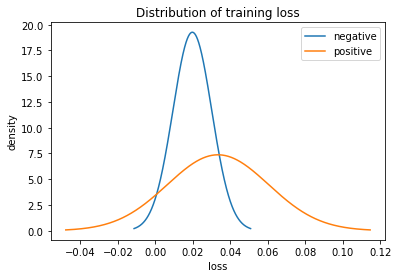

In [36]:
plt.title('Distribution of training loss')
plt.xlabel('loss')
plt.ylabel('density')
plot_normal_distribution(np.mean(true_loss), np.var(true_loss), 0.5)
plot_normal_distribution(np.mean(false_loss), np.var(false_loss), 0.5)
plt.legend(['negative', 'positive'])

In [37]:
intersection = solve_intersection(np.mean(true_loss), np.mean(false_loss), np.var(true_loss), np.var(false_loss), 0.5, 0.5)
print(intersection)

[0.03403441 0.00064003]


In [38]:
X_test = torch.cat((X_true_test, X_false_test), 0)
y_test = torch.cat((y_true_test, y_false_test), 0)
y_test_hat = test_model.forward(X_test)
test_loss = criterion(y_test_hat, X_test)
test_acc = binary_acc(torch.mean(test_loss, dim=1), y_test, intersection[0])
precision, recall = get_precision_and_recall(torch.mean(test_loss, dim=1), y_test, intersection[0])
f1 = 2*(precision*recall)/(precision+recall)
print(test_acc, precision, recall, f1)

tensor(0.7125) tensor(0.7713) tensor(0.4164) tensor(0.5408)


### Feature Importances Analysis

In [ ]:
!pip install eli5

In [ ]:
import numpy as np
from eli5.permutation_importance import get_score_importances

# ... load data, define score function
def score(X, y):
    X = torch.from_numpy(X)
    y = torch.from_numpy(y)
    y_pred = test_model.forward(X)
    test_loss = criterion(y_pred, X)
    test_acc = binary_acc(torch.mean(test_loss, dim=1), y, intersection[0])
    precision, recall = get_precision_and_recall(torch.mean(test_loss, dim=1), y, intersection[0])
    precision = precision.numpy()
    recall = recall.numpy()
    return 2*(precision*recall)/(precision+recall)

base_score, score_decreases = get_score_importances(score, X_test.numpy(), y_test.numpy())
feature_importances = np.mean(score_decreases, axis=0)

In [ ]:
feature_importances

In [ ]:
import pandas as pd

FI = {'Features':  list(normalized_data.drop('TRANSACTIONCANCELLED', axis=1).columns.values),
        'Feature Importances': list(feature_importances)}

Feature_Importance = pd.DataFrame(FI)

In [ ]:
Feature_Importance

In [ ]:
sorted_FI = Feature_Importance.sort_values(by='Feature Importances', ascending = False)
sorted_FI.reset_index(inplace=True)
sorted_FI.drop("index", axis = 1, inplace= True)
sorted_FI

In [ ]:
sorted_FI.head(32)